#Загрузка

In [ ]:
# -*- coding: utf8 -*-
import pandas as pd
import numpy as np
import math
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import warnings
from google.colab import drive
from google.colab import files
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report

warnings.simplefilter("ignore")

In [ ]:
drive.mount('/content/gdrive')

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/sas_data.csv', sep = ';')

In [ ]:
def load():
    #возвращает исходные данные
    data = pd.read_csv('/content/gdrive/My Drive/sas_data/project.csv', sep = ',')
    return data

In [ ]:
def load_full():
    #возвращает уже заполненные данные
    #data = pd.read_csv('/content/gdrive/My Drive/sas_data/full_data.csv', sep = ',')
    data = pd.read_csv('/content/gdrive/My Drive/sas_data/data_redemp.csv', sep = ',')
    data.drop('Unnamed: 0', axis=1, inplace=True)
    return data

In [ ]:
def load_final():
    #возвращает заполненные данные c новыми столбцами
    data = pd.read_csv('/content/gdrive/My Drive/sas_data/data_100.csv', sep = ',')
    data.drop('Unnamed: 0', axis=1, inplace=True)
    return data

#Вспомогательные функции

In [ ]:
def drop_columns(data):
    data.drop(['ID_SKU', 'ГодДатыЗаказа', 'НомерСтроки', 'СуммаУслуг', 'МагазинЗаказа'], axis=1, inplace=True)
    #в столбце МагазинЗаказа более 99% пропусков
    #НомерСтроки не несет в себе полезной информации
    #Год заказа для всех товаров одинаковый, так что тоже нет пользы
    return data

In [ ]:
def convert_features_to_valid_datatype(data, num_features):
  #Преобразуем числовые признаки к нужному типу данных

  data[num_features] = data[num_features].astype(str)

  for c in num_features:
      data[c] = data[c].apply(lambda el: el.replace(',', '.'))

  for c in num_features:
      data[c] = data[c].apply(lambda el: el.replace(' ', ''))

  data[num_features] = data[num_features].astype(float)
  return data

In [ ]:
#Заполнение пропусков

def fill_data(data):

    #Заполнение пропусков в столбце 'Причина отмены'
    data.loc[((data['ПричинаОтмены'].isnull()) & (data['Отменено'] == 'Нет')), 'ПричинаОтмены'] = 'не отменено'
    data.loc[((data['ПричинаОтмены'].isnull()) & (data['Отменено'] == 'Да')), 'ПричинаОтмены'] = 'не указано'

    #Заполнение пропусков по почте и клиенту
    data.loc[(data['ЭлектроннаяПочта_new'].isnull()), 'ЭлектроннаяПочта_new'] = 'нет данных'
    data.loc[(data['Клиент'].isnull()), 'Клиент'] = 'нет данных'

    #Посмотрим на "гео" всех пропущенных позиций в столбце "Регион"
    data.loc[(data['Регион'].isnull()), 'Регион'] = 'Регионы'
    data.drop('Гео', axis=1, inplace=True)

    data.loc[(data['ДатаДоставки'].isnull()) & (data['Отменено'] == 'Да'), 'ДатаДоставки'] = 'Заказ отменен'
    data.loc[(data['МетодДоставки'].isnull())  & (data['Отменено'] == 'Да'), 'МетодДоставки'] = 'Заказ отменен'
    data.loc[(data['ФормаОплаты'].isnull())  & (data['Отменено'] == 'Да'), 'ФормаОплаты'] = 'Заказ отменен' 

    #Для столбца 'ТипТовара' пропуски наблюдаются только в строках, отвечающих за Доставку, поэтому заполним его соответствующе
    data.loc[(data['ТипТовара'].isnull())  & (data['Номенклатура'] == 'Доставка'), 'ТипТовара'] = 'Доставка'

    #Заполним столбец с кодом пунктов выдачи заказов(пвз)
    #data.loc[data['ПВЗ_код'].isnull(), 'НовыйСтатус'].unique()
    #как видно, ПВЗ_код пустой для товаров, которые не дошли до ПВЗ
    data.loc[data['ПВЗ_код'].isnull(), 'ПВЗ_код'] = 'Не доставлено в ПВЗ'

    #Те строки, где пропуски в столбцах группа2, группа3 и группа4 - это доставка
    #Заполним их новым значением - Доставка
    data.loc[(data['Группа2'].isnull()) & (data['Номенклатура'] == 'Доставка'), 'Группа2'] = 'Доставка'
    data.loc[(data['Группа3'].isnull()) & (data['Номенклатура'] == 'Доставка'), 'Группа3'] = 'Доставка'
    data.loc[(data['Группа4'].isnull()) & (data['Номенклатура'] == 'Доставка'), 'Группа4'] = 'Доставка'

    #Заполним оставшиеся пропуски в признаке "Группа4", для этого продублируем туда значения из признака "Группа3" 
    #(так между разными товарами будет хоть какая-то разница по этому признаку, чем если бы мы заполняли все наны одинаково)
    data.loc[(data['Группа4'].isnull()) & (data['Номенклатура'] != 'Доставка'), 'Группа4'] = data.loc[(data['Группа4'].isnull()) & (data['Номенклатура'] != 'Доставка'), 'Группа3']
    
    #Заполнение пропусков в столбце 'Цена Закупки'
    #Пропуски, соответствующие доставке, заполним 0
    #Для остальных строк посмотрим, известна ли цена на позиции с такой же номенклатурой
    #Если известна, тогда возьмем среднее значение
    data.loc[(data['ЦенаЗакупки'].isnull()) & (data['Номенклатура'] == 'Доставка'), 'ЦенаЗакупки'] = 0
    arr = data.loc[data['ЦенаЗакупки'].isnull(), 'Номенклатура'].unique()
    arr = np.delete(arr, 0)
    for i in arr:
        val = data.loc[(data['Номенклатура'] == i) & (data['ЦенаЗакупки'].notnull())]['ЦенаЗакупки'].unique()
        if (len(val) >= 1):
            data.loc[(data['ЦенаЗакупки'].isnull()) & (data['Номенклатура'] == i), 'ЦенаЗакупки'] = np.mean(val)

    #Если цена товара с такой же номенклатурой неизвестна, тогда посмотрим на среднюю цену закупки товаров той же группы4
    d = data.loc[data['ЦенаЗакупки'].isnull()]['Группа4'].unique()
    for el in d:
        cost = data[(data['Группа4'] == el) & (data['ЦенаЗакупки'].notnull())]['ЦенаЗакупки'].unique()
        if (len(cost) != 0):
            data.loc[(data['ЦенаЗакупки'].isnull()) & (data['Группа4'] == el), 'ЦенаЗакупки'] = np.mean(cost)
    
    #Заполним пропуски в столбце 'Маржа' как разницу суммы строки и цены закупки
    ind = data[(data['Маржа'].isnull())].index
    data.loc[ind, 'Маржа'] = data.loc[ind, 'СуммаСтроки'] - data.loc[ind, 'ЦенаЗакупки']

    return data

In [ ]:
def any_gaps(data): #проверка на наличие пропусков
    null_array = data.isnull().sum()
    if null_array.sum() == 0:
        print('Пропусков не осталось.')
    else:
        print('Остались пропуски в колонках:')
        for i in range(len(null_array)):
            if null_array[i] != 0:
                print('\t', data.columns[i], null_array[i])

#Подготовка данных

In [ ]:
#разделим признаки на числовые и категориальные

num_features = ['СуммаЗаказаНаСайте', 'СуммаДокумента', 'Цена', 'СуммаСтроки', 'ЦенаЗакупки', 'Маржа', 'СуммаУслуг', 'СуммаДоставки']

cat_features = ['Дата', 'ДатаДоставки', 'НомерЗаказаНаСайте', 'НовыйСтатус', 'МетодДоставки',
'ФормаОплаты', 'Регион', 'Группа2', 'Группа3', 'Группа4', 'Тип', 'Номенклатура',
'ТипТовара', 'Отменено', 'ПричинаОтмены', 'Количество', 'МесяцДатыЗаказа', 'ПВЗ_код',
'Статус', 'КоличествоПроданоКлиенту', 'ДатаЗаказаНаСайте', 'Телефон_new',
'ЭлектроннаяПочта_new', 'Клиент', 'ГородМагазина']

In [ ]:
df = load()

In [ ]:
df = convert_features_to_valid_datatype(df, num_features)

In [ ]:
#Посчитаем количество пропусков и уникальных значений для каждого из столбцов.

names = ['Кол-во уникальных значений', 'Процент уникальных значений', 'Кол-во пропусков', 'Процент пропусков']
res = pd.DataFrame(index = df.columns, columns=names)

res['Кол-во уникальных значений'] = df.nunique().values
#количество уникальных значений считается без учета NaN
res['Процент уникальных значений'] = round(res['Кол-во уникальных значений'] * 100 / df.shape[0], 2)

res['Кол-во пропусков'] = df.isna().sum().values
res['Процент пропусков'] = round(res['Кол-во пропусков'] * 100 / df.shape[0], 2)

res

,Кол-во уникальных значений,Процент уникальных значений,Кол-во пропусков,Процент пропусков
Дата,26061,3.27,0,0.00
ДатаДоставки,107,0.01,682,0.09
НомерЗаказаНаСайте,170355,21.37,0,0.00
НовыйСтатус,14,0.00,0,0.00
СуммаЗаказаНаСайте,15391,1.93,0,0.00
СуммаДокумента,14909,1.87,0,0.00
МетодДоставки,6,0.00,54,0.01
ФормаОплаты,2,0.00,55,0.01
Регион,491,0.06,4919,0.62
Группа2,13,0.00,157628,19.77


In [ ]:
df = drop_columns(df)

Заполним пропуски.

In [ ]:
df = fill_data(df)

In [ ]:
any_gaps(df)

Остались пропуски в колонках:
	 ДатаДоставки 7
	 МетодДоставки 5
	 ФормаОплаты 5
	 ЦенаЗакупки 6
	 Маржа 6


In [ ]:
#Удалим оставшиеся строки

del_ind = df.loc[(df['ДатаДоставки'].isnull())].index
df.drop(del_ind, axis = 0, inplace = True)
del_ind = df.loc[(df['ЦенаЗакупки'].isnull())].index
df.drop(del_ind, axis = 0, inplace = True)
df = df.reset_index()
df.drop('index', axis = 1, inplace = True)

In [ ]:
any_gaps(df)

Пропусков не осталось.


In [ ]:
df.drop

<bound method DataFrame.drop of                     Дата     ДатаДоставки  ...    Клиент ГородМагазина
0        01.07.2017 0:00  06.07.2017 0:00  ...   Татьяна             0
1        01.07.2017 0:00  06.07.2017 0:00  ...   Татьяна             0
2        01.07.2017 0:00  06.07.2017 0:00  ...   Татьяна             0
3        01.07.2017 0:00  06.07.2017 0:00  ...   Татьяна             0
4        01.07.2017 0:00  06.07.2017 0:00  ...   Татьяна             0
...                  ...              ...  ...       ...           ...
797174  31.08.2017 23:42  06.09.2017 0:00  ...  Виктория             0
797175  31.08.2017 23:42  06.09.2017 0:00  ...  Виктория             0
797176  31.08.2017 23:42  06.09.2017 0:00  ...  Виктория             0
797177  31.08.2017 23:42  06.09.2017 0:00  ...  Виктория             0
797178  31.08.2017 23:42  06.09.2017 0:00  ...  Виктория             0

[797179 rows x 32 columns]>

In [ ]:
df.to_csv('full_data.csv')

#Выкупленность товара

In [ ]:
#df = load_full()

Будем определять выкупленность товара по следующим признакам:

*   Новый статус (= доставлен)
*   Отменено (= нет)
*   Количество ($\neq 0$)
*   Количество продано клиенту ($\neq 0$)

Если количество товаров совпадает с количеством, проданным клиенту, тогда товар выкуплен полностью. Если же данные параметры не равны, тогда товар считается выкупленным частично. Для таких случаев посчитаем долю выкупленного товара.

In [ ]:
df['Выкуплен ли товар полностью'] = [0]*df.shape[0]
df['Выкуплен ли товар частично'] = [0]*df.shape[0]
df['Отношение кол-ва проданных товаров к заказанным'] = [0]*df.shape[0]

In [ ]:
index_1 = df[(df['НовыйСтатус'] == 'Доставлен') & (df['Отменено'] == 'Нет') & 
             (df['КоличествоПроданоКлиенту'] == df['Количество']) & (df['КоличествоПроданоКлиенту'] != 0)].index
             
df.loc[index_1, 'Выкуплен ли товар полностью'] = 1

In [ ]:
index_2 = df[(df['НовыйСтатус'] == 'Доставлен') & (df['Отменено'] == 'Нет') &
             (df['КоличествоПроданоКлиенту'] != df['Количество']) & (df['Количество'] != 0) & (df['КоличествоПроданоКлиенту'] != 0)].index

df.loc[index_2, 'Выкуплен ли товар частично'] = 1
df.loc[index_2, 'Отношение кол-ва проданных товаров к заказанным'] = df.loc[index_2]['КоличествоПроданоКлиенту']/df.loc[index_2]['Количество']

In [ ]:
df.to_csv('data_redemp.csv')

#Уникальный идентификатор клиента

In [ ]:
df = load_full()

Предположительно, телефон является уникальным иднтификатором клиента. Проверим, так ли это. 

In [ ]:
df.groupby('Телефон_new').count()[['НомерЗаказаНаСайте']]

,НомерЗаказаНаСайте
Телефон_new,
0,2081
49574954-56524849545119,2
51534957-48525550515032,3
51535448-48484848484830,6
51555348-48484848484830,2
...,...
57545355-53485748575799,1
57545549-57544957525799,4
57555555-55564848524890,2


Для 2081 клиента телефон отсутствует. Для них в качестве идентификатора можно использовать почту (если она не пустая).

In [ ]:
df[(df['Телефон_new'] == '0') & (df['ЭлектроннаяПочта_new'] == 'нет данных')]

,Дата,ДатаДоставки,НомерЗаказаНаСайте,НовыйСтатус,СуммаЗаказаНаСайте,СуммаДокумента,МетодДоставки,ФормаОплаты,Регион,Группа2,Группа3,Группа4,Тип,Номенклатура,ТипТовара,Отменено,ПричинаОтмены,Количество,Цена,СуммаСтроки,ЦенаЗакупки,МесяцДатыЗаказа,ПВЗ_код,Статус,Маржа,СуммаДоставки,КоличествоПроданоКлиенту,ДатаЗаказаНаСайте,Телефон_new,ЭлектроннаяПочта_new,Клиент,ГородМагазина,Выкуплен ли товар полностью,Выкуплен ли товар частично,Отношение кол-ва проданных товаров к заказанным
23229,03.07.2017 10:11,05.07.2017 0:00,5046029_TR,Доставлен,4411.0,4411.0,Магазины,Безналичная,Москва,"ТЕКСТИЛЬ, ТРИКОТАЖ",ДЕТСКАЯ ОДЕЖДА (2-6 лет),комплекты,ОДЕЖДА,"SILVERSUN, КОМПЛЕКТ (футболка+капри), (желт), ...",МГТ,Нет,не отменено,1,699.0,699.0,495.00,7,23111,Доставлен,204.00,49.0,1,03.07.2017 0:00,0,нет данных,гость,0,1,0,0.0
23230,03.07.2017 10:11,05.07.2017 0:00,5046029_TR,Доставлен,4411.0,4411.0,Магазины,Безналичная,Москва,"ТЕКСТИЛЬ, ТРИКОТАЖ",ДЕТСКАЯ ОДЕЖДА (2-6 лет),комплекты,ОДЕЖДА,"SILVERSUN, КОМПЛЕКТ (майка+шорты), (роз), р.104",МГТ,Нет,не отменено,1,799.0,799.0,540.00,7,23111,Доставлен,259.00,49.0,1,03.07.2017 0:00,0,нет данных,гость,0,1,0,0.0
23231,03.07.2017 10:11,05.07.2017 0:00,5046029_TR,Доставлен,4411.0,4411.0,Магазины,Безналичная,Москва,"ТЕКСТИЛЬ, ТРИКОТАЖ","ГОЛОВНЫЕ УБОРЫ, ВАРЕЖКИ, ПЕРЧАТКИ",головные уборы,ОДЕЖДА,"MAGROF, БЕЙСБОЛКА (роз), р. 52",МГТ,Нет,не отменено,1,269.0,269.0,184.26,7,23111,Доставлен,84.74,49.0,1,03.07.2017 0:00,0,нет данных,гость,0,1,0,0.0
23232,03.07.2017 10:11,05.07.2017 0:00,5046029_TR,Доставлен,4411.0,4411.0,Магазины,Безналичная,Москва,"ТЕКСТИЛЬ, ТРИКОТАЖ",ДЕТСКОЕ БЕЛЬЁ,домашние комплекты,ОДЕЖДА,"CORNETTE, ПИЖАМА Ice cream, р. 98-104, Польша",МГТ,Нет,не отменено,1,899.0,899.0,370.90,7,23111,Доставлен,528.10,49.0,1,03.07.2017 0:00,0,нет данных,гость,0,1,0,0.0
23233,03.07.2017 10:11,05.07.2017 0:00,5046029_TR,Доставлен,4411.0,4411.0,Магазины,Безналичная,Москва,"ТЕКСТИЛЬ, ТРИКОТАЖ",ДЕТСКОЕ БЕЛЬЁ,трусы,ОДЕЖДА,"TIGER, ТРУСЫ (фиолет), р. 98-104",МГТ,Нет,не отменено,2,149.0,298.0,95.40,7,23111,Доставлен,107.20,49.0,2,03.07.2017 0:00,0,нет данных,гость,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766967,29.08.2017 18:23,02.09.2017 0:00,5403018_TR,Отменен,1101.0,300.0,Курьерская,Наличная,Москва,"ТЕКСТИЛЬ, ТРИКОТАЖ",ПОСТЕЛЬНОЕ БЕЛЬЕ,пеленки,ОДЕЖДА,"ЗВЕЗДОЧКА, ПЕЛЕНКА (трикотаж), (80*120 см)",МГТ,Да,"1.1 Тест, контрольная закупка",1,179.0,179.0,115.00,8,23111,Отменен,64.00,300.0,0,29.08.2017 0:00,0,нет данных,Гость,0,0,0,0.0
766978,29.08.2017 20:13,02.09.2017 0:00,5403084_TR,Отменен,28361.0,150.0,Курьерская,Наличная,Владимир,ДЕТСКОЕ ПИТАНИЕ,НАПИТКИ,соки,ППКП,"ФРУТОНЯНЯ, НЕКТАР банановый с мяк., (500мл)",МГТ,Да,"1.1 Тест, контрольная закупка",5,32.0,160.0,31.79,8,Не доставлено в ПВЗ,Отменен,1.05,150.0,5,29.08.2017 0:00,0,нет данных,Гость,0,0,0,0.0
766979,29.08.2017 20:13,02.09.2017 0:00,5403084_TR,Отменен,28361.0,150.0,Курьерская,Наличная,Владимир,ДЕТСКОЕ ПИТАНИЕ,ПЮРЕ,пюре овощные,ППКП,"ГЕРБЕР, ПЮРЕ брокколи, с 4 мес., (130г)",МГТ,Да,"1.1 Тест, контрольная закупка",11,51.0,561.0,47.50,8,Не доставлено в ПВЗ,Отменен,38.50,150.0,11,29.08.2017 0:00,0,нет данных,Гость,0,0,0,0.0
766980,29.08.2017 20:13,02.09.2017 0:00,5403084_TR,Отменен,28361.0,150.0,Курьерская,Наличная,Владимир,Доставка,Доставка,Доставка,ИНОЕ,Доставка,Доставка,Нет,не отменено,1,150.0,150.0,0.00,8,Не доставлено в ПВЗ,Отменен,150.00,150.0,1,29.08.2017 0:00,0,нет данных,Гость,0,0,0,0.0


Следовательно, будем использовать почту для оставшихся клиентов.

In [ ]:
ind = df[df['Телефон_new'] == '0'].index
df.loc[ind, 'Телефон_new'] = df.loc[ind, 'ЭлектроннаяПочта_new']

Теперь телефон можно считать уникальным идентификатором клиента.

#Пересчет выручки и маржи

**Количество  VS  Количество продано клиенту**

Посмотрим для начала на столбцы 'Количество' и 'Количество продано клиенту'.

In [ ]:
print('Количество = Количество продано клиенту в', round(len(df[df['Количество'] == df['КоличествоПроданоКлиенту']])/len(df)*100, 2), '% случаев.')
print('Количество > Количество продано клиенту в', round(len(df[df['Количество'] > df['КоличествоПроданоКлиенту']])/len(df)*100, 2), '% случаев.')
print('Количество < Количество продано клиенту в', round(len(df[df['Количество'] < df['КоличествоПроданоКлиенту']])/len(df)*100, 2), '% случаев.')

Количество = Количество продано клиенту в 83.75 % случаев.
Количество > Количество продано клиенту в 13.47 % случаев.
Количество < Количество продано клиенту в 2.77 % случаев.


In [ ]:
df[(df['Количество'] < df['КоличествоПроданоКлиенту']) & (df['НовыйСтатус'] == 'Доставлен') & (df['Отменено'] == 'Нет')]

,Дата,ДатаДоставки,НомерЗаказаНаСайте,НовыйСтатус,СуммаЗаказаНаСайте,СуммаДокумента,МетодДоставки,ФормаОплаты,Регион,Группа2,Группа3,Группа4,Тип,Номенклатура,ТипТовара,Отменено,ПричинаОтмены,Количество,Цена,СуммаСтроки,ЦенаЗакупки,МесяцДатыЗаказа,ПВЗ_код,Статус,Маржа,СуммаДоставки,КоличествоПроданоКлиенту,ДатаЗаказаНаСайте,Телефон_new,ЭлектроннаяПочта_new,Клиент,ГородМагазина,Выкуплен ли товар полностью,Выкуплен ли товар частично,Отношение кол-ва проданных товаров к заказанным


Выявлено примерно 3% случаев, когда 'Количество' < 'Количество продано клиенту'. Такая ситуация кажется ошибочной, поскольку нельзя продать больше, чем клиент заказал. Среди этих 3% все позиции отменены/не доставлены.

In [ ]:
ind = df[(df['Количество'] < df['КоличествоПроданоКлиенту'])].index
df.loc[ind, 'Количество'] = df.loc[ind, 'КоличествоПроданоКлиенту']

**Выручка**

Выручка = цена товара * кол-во проданного товара * флаг выкупленности товара

In [ ]:
df.loc[:, 'Выручка(new)'] = df.loc[:, 'Цена'] * df.loc[:, 'КоличествоПроданоКлиенту'] * (df.loc[:,'Выкуплен ли товар полностью'] + df.loc[:,'Выкуплен ли товар частично'])

**Маржа**

Маржа = выручка - цена закупки * количество

(в данном случае учитывается именно количество, так как в случае отмены или возврата деньги, выплаченные магазином поставщику, не возвращаются, как и товары)



In [ ]:
df.loc[:, 'Маржа(new)'] = df.loc[:, 'Выручка(new)'] - df.loc[:, 'ЦенаЗакупки'] * df.loc[:, 'КоличествоПроданоКлиенту'] * (df.loc[:,'Выкуплен ли товар полностью'] + df.loc[:,'Выкуплен ли товар частично'])

In [ ]:
df.to_csv('data_100.csv')

#Визуализация

In [ ]:
#colors = ['lightcoral', 'skyblue', 'sandybrown', 'thistle', 'silver', 'lightpink', 'cadetblue', 'darkkhaki', 'goldenrod', 'plum']

In [ ]:
#df = load_full()

In [ ]:
df['МесяцДатыЗаказа'].unique()

array([7, 8])

In [ ]:
month = ['июль', 'август']

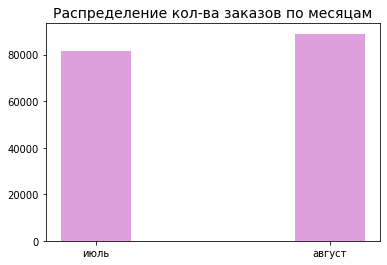

In [ ]:
#Распределение кол-ва заказов по месяцам
plt.figure()
count_jul = len(df[df['МесяцДатыЗаказа'] == 7]['НомерЗаказаНаСайте'].unique())
count_aug = len(df[df['МесяцДатыЗаказа'] == 8]['НомерЗаказаНаСайте'].unique())
plt.bar(month, [count_jul, count_aug], width=0.3, color = 'plum')
plt.title('Распределение кол-ва заказов по месяцам', fontsize = 14)
plt.show()

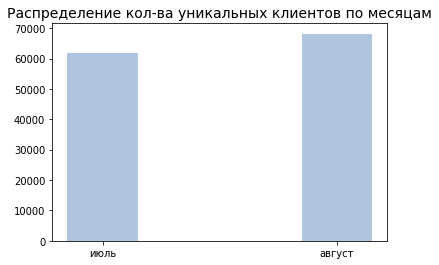

In [ ]:
#Распределение кол-ва уникальных клиентов по месяцам
plt.figure()
count_jul = len(df[df['МесяцДатыЗаказа'] == 7]['Телефон_new'].unique())
count_aug = len(df[df['МесяцДатыЗаказа'] == 8]['Телефон_new'].unique())
plt.bar(month, [count_jul, count_aug], width=0.3, color = 'lightsteelblue')
plt.title('Распределение кол-ва уникальных клиентов по месяцам', fontsize = 14)
plt.show()

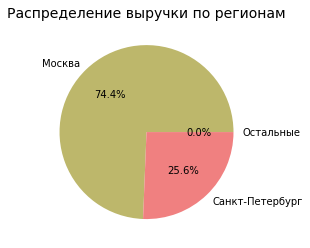

In [ ]:
reg = ['Москва', 'Санкт-Петербург', 'Остальные']
plt.figure()
count_msk = df[df['Регион'] == reg[0]]['Выручка(new)'].sum()
count_sp = df[df['Регион'] == reg[1]]['Выручка(new)'].sum()
count_oth = df[df['Регион'] == reg[2]]['Выручка(new)'].sum()
plt.pie([count_msk, count_sp, count_oth], labels = reg, autopct='%1.1f%%', colors = ['darkkhaki', 'lightcoral', 'black'])
plt.title('Распределение выручки по регионам', fontsize = 14)
plt.show()

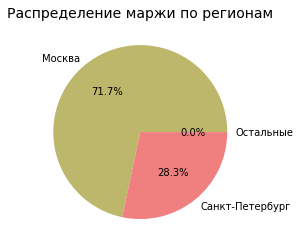

In [ ]:
reg = ['Москва', 'Санкт-Петербург', 'Остальные']
plt.figure()
count_msk = df[df['Регион'] == reg[0]]['Маржа(new)'].sum()
count_sp = df[df['Регион'] == reg[1]]['Маржа(new)'].sum()
count_oth = df[df['Регион'] == reg[2]]['Маржа(new)'].sum()
plt.pie([count_msk, count_sp, count_oth], labels = reg, autopct='%1.1f%%', colors = ['darkkhaki', 'lightcoral', 'black'])
plt.title('Распределение маржи по регионам', fontsize = 14)
plt.show()

In [ ]:
#Посмотрим на причины, по которым отменяют заказы
df['ПричинаОтмены'].value_counts()

#Разделение данных на обучающую и тестовую выборки

In [ ]:
df_jul = copy(df[df['МесяцДатыЗаказа'] == 7])
df_aug = copy(df[df['МесяцДатыЗаказа'] == 8])

#Группировка по клиентам

In [ ]:
names = ['Информация о клиенте(телефон/почта)', 'Дата первого заказа', 'Дата последнего заказа', 'Кол-во заказов', 'Кол-во выкупленных заказов', 'Среднее кол-во товаров в чеке', 
         'Выручка по всем заказам', 'Выручка по выкупленным заказам', 'Cредняя выручка по выкупленным заказам', 
         'Маржа по всем заказам', 'Маржа по выкупленным заказам', 'Средняя маржа по выкупленным заказам']

**Обучающая выборка**

In [ ]:
ident_jul = df_jul['Телефон_new'].unique()

In [ ]:
len(ident_jul)

61759

In [ ]:
clients_jul = pd.DataFrame(columns=names)

In [ ]:
for i in range(0, len(ident_jul)):
    telefon = ident_jul[i]
    clients_jul.loc[i, 'Информация о клиенте(телефон/почта)'] = telefon

    date = df_jul[df_jul['Телефон_new'] == telefon]['ДатаЗаказаНаСайте'].unique()
    clients_jul.loc[i, 'Дата первого заказа'] = date[0]
    if len(date) > 1:
        clients_jul.loc[i, 'Дата последнего заказа'] = date[len(date) - 1]
    else:
        clients_jul.loc[i, 'Дата последнего заказа'] = date[0]

    clients_jul.loc[i, 'Кол-во заказов'] = len(df_jul[(df_jul['Телефон_new'] == telefon)]['НомерЗаказаНаСайте'].unique())
    clients_jul.loc[i, 'Кол-во выкупленных заказов'] = len(df_jul[(df_jul['Телефон_new'] == telefon) & ((df_jul['Выкуплен ли товар полностью'] == 1) | (df_jul['Выкуплен ли товар частично'] == 1))]['НомерЗаказаНаСайте'].unique())
    clients_jul.loc[i, 'Среднее кол-во товаров в чеке'] = len(df_jul[df_jul['Телефон_new'] == telefon]) / clients_jul.loc[i, 'Кол-во заказов']

    clients_jul.loc[i, 'Выручка по всем заказам'] = df_jul[df_jul['Телефон_new'] == telefon]['Выручка(new)'].sum()
    clients_jul.loc[i, 'Выручка по выкупленным заказам'] = df_jul[(df_jul['Телефон_new'] == telefon) & ((df_jul['Выкуплен ли товар полностью'] == 1) | (df_jul['Выкуплен ли товар частично'] == 1))]['Выручка(new)'].sum()
    if (clients_jul.loc[i, 'Кол-во выкупленных заказов'] > 0):
        clients_jul.loc[i, 'Cредняя выручка по выкупленным заказам'] = df_jul[(df_jul['Телефон_new'] == telefon) & ((df_jul['Выкуплен ли товар полностью'] == 1) | (df_jul['Выкуплен ли товар частично'] == 1))]['Выручка(new)'].mean()
    else:
        clients_jul.loc[i, 'Cредняя выручка по выкупленным заказам'] = 0


    clients_jul.loc[i, 'Маржа по всем заказам'] = df_jul[df_jul['Телефон_new'] == telefon]['Маржа(new)'].sum()
    clients_jul.loc[i, 'Маржа по выкупленным заказам'] = df_jul[(df_jul['Телефон_new'] == telefon) & ((df_jul['Выкуплен ли товар полностью'] == 1) | (df_jul['Выкуплен ли товар частично'] == 1))]['Маржа(new)'].sum()
    if (clients_jul.loc[i, 'Кол-во выкупленных заказов'] > 0):
        clients_jul.loc[i, 'Средняя маржа по выкупленным заказам'] = df_jul[(df_jul['Телефон_new'] == telefon) & ((df_jul['Выкуплен ли товар полностью'] == 1) | (df_jul['Выкуплен ли товар частично'] == 1))]['Маржа(new)'].mean()
    else:
        clients_jul.loc[i, 'Средняя маржа по выкупленным заказам'] = 0

**Тестовая выборка**

In [ ]:
ident_aug = df_aug['Телефон_new'].unique()

In [ ]:
len(ident_aug)

68162

In [ ]:
clients_aug = pd.DataFrame(columns=names)

In [ ]:
for i in range(0, len(ident_aug)):
    if i % 1000 == 0:
        print('Обработано', i, 'клиентов')
    telefon = ident_aug[i]
    clients_aug.loc[i, 'Информация о клиенте(телефон/почта)'] = telefon

    date = df_aug[df_aug['Телефон_new'] == telefon]['ДатаЗаказаНаСайте'].unique()
    clients_aug.loc[i, 'Дата первого заказа'] = date[0]
    if len(date) > 1:
        clients_aug.loc[i, 'Дата последнего заказа'] = date[len(date) - 1]
    else:
        clients_aug.loc[i, 'Дата последнего заказа'] = date[0]

    clients_aug.loc[i, 'Кол-во заказов'] = len(df_aug[(df_aug['Телефон_new'] == telefon)]['НомерЗаказаНаСайте'].unique())
    clients_aug.loc[i, 'Кол-во выкупленных заказов'] = len(df_aug[(df_aug['Телефон_new'] == telefon) & ((df_aug['Выкуплен ли товар полностью'] == 1) | (df_aug['Выкуплен ли товар частично'] == 1))]['НомерЗаказаНаСайте'].unique())
    clients_aug.loc[i, 'Среднее кол-во товаров в чеке'] = len(df_aug[df_aug['Телефон_new'] == telefon]) / clients_aug.loc[i, 'Кол-во заказов']

    clients_aug.loc[i, 'Выручка по всем заказам'] = df_aug[df_aug['Телефон_new'] == telefon]['Выручка(new)'].sum()
    clients_aug.loc[i, 'Выручка по выкупленным заказам'] = df_aug[(df_aug['Телефон_new'] == telefon) & ((df_aug['Выкуплен ли товар полностью'] == 1) | (df_aug['Выкуплен ли товар частично'] == 1))]['Выручка(new)'].sum()
    if (clients_aug.loc[i, 'Кол-во выкупленных заказов'] > 0):
        clients_aug.loc[i, 'Cредняя выручка по выкупленным заказам'] = df_aug[(df_aug['Телефон_new'] == telefon) & ((df_aug['Выкуплен ли товар полностью'] == 1) | (df_aug['Выкуплен ли товар частично'] == 1))]['Выручка(new)'].mean()
    else:
        clients_aug.loc[i, 'Cредняя выручка по выкупленным заказам'] = 0

    clients_aug.loc[i, 'Маржа по всем заказам'] = df_aug[df_aug['Телефон_new'] == telefon]['Маржа(new)'].sum()
    clients_aug.loc[i, 'Маржа по выкупленным заказам'] = df_aug[(df_aug['Телефон_new'] == telefon) & ((df_aug['Выкуплен ли товар полностью'] == 1) | (df_aug['Выкуплен ли товар частично'] == 1))]['Маржа(new)'].sum()
    if (clients_aug.loc[i, 'Кол-во выкупленных заказов'] > 0):
        clients_aug.loc[i, 'Средняя маржа по выкупленным заказам'] = df_aug[(df_aug['Телефон_new'] == telefon) & ((df_aug['Выкуплен ли товар полностью'] == 1) | (df_aug['Выкуплен ли товар частично'] == 1))]['Маржа(new)'].mean()
    else:
        clients_aug.loc[i, 'Средняя маржа по выкупленным заказам'] = 0

Обработано 0 клиентов
Обработано 1000 клиентов
Обработано 2000 клиентов
Обработано 3000 клиентов
Обработано 4000 клиентов
Обработано 5000 клиентов
Обработано 6000 клиентов
Обработано 7000 клиентов
Обработано 8000 клиентов
Обработано 9000 клиентов
Обработано 10000 клиентов
Обработано 11000 клиентов
Обработано 12000 клиентов
Обработано 13000 клиентов
Обработано 14000 клиентов
Обработано 15000 клиентов
Обработано 16000 клиентов
Обработано 17000 клиентов
Обработано 18000 клиентов
Обработано 19000 клиентов
Обработано 20000 клиентов
Обработано 21000 клиентов
Обработано 22000 клиентов
Обработано 23000 клиентов
Обработано 24000 клиентов
Обработано 25000 клиентов
Обработано 26000 клиентов
Обработано 27000 клиентов
Обработано 28000 клиентов
Обработано 29000 клиентов
Обработано 30000 клиентов
Обработано 31000 клиентов
Обработано 32000 клиентов
Обработано 33000 клиентов
Обработано 34000 клиентов
Обработано 35000 клиентов
Обработано 36000 клиентов
Обработано 37000 клиентов
Обработано 38000 клиентов

**Целевая переменная**

In [ ]:
for i in range(0, len(ident_jul)):
    telefon = ident_jul[i]
    if telefon in ident_aug:   
        clients_jul.loc[i, 'Вернулся ли клиент в след. месяце'] = 1
    else:
        clients_jul.loc[i, 'Вернулся ли клиент в след. месяце'] = 0

In [ ]:
clients_aug.to_csv('clients_aug.csv', index=False)
files.download("clients_aug.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
clients_aug

,Информация о клиенте(телефон/почта),Дата первого заказа,Дата последнего заказа,Кол-во заказов,Кол-во выкупленных заказов,Среднее кол-во товаров в чеке,Выручка по всем заказам,Выручка по выкупленным заказам,Cредняя выручка по выкупленным заказам,Маржа по всем заказам,Маржа по выкупленным заказам,Средняя маржа по выкупленным заказам
0,55574857-54525253565078,31.07.2017 0:00,31.07.2017 0:00,1,0,4,0,0,0,0,0,0
1,55575054-57525256564978,31.07.2017 0:00,31.07.2017 0:00,1,1,7,1763,1763,251.857,291.4,291.4,41.6286
2,55575653-49575751545379,31.07.2017 0:00,31.07.2017 0:00,1,0,6,0,0,0,0,0,0
3,55574851-55535749575173,31.07.2017 0:00,09.08.2017 0:00,3,0,8.33333,0,0,0,0,0,0
4,55574857-50575453545775,31.07.2017 0:00,08.08.2017 0:00,2,2,2.5,5086,5086,1017.2,1694.68,1694.68,338.936
...,...,...,...,...,...,...,...,...,...,...,...,...
68157,55575653-52495348485078,31.08.2017 0:00,31.08.2017 0:00,1,0,4,0,0,0,0,0,0
68158,55575349-53505051515379,31.08.2017 0:00,31.08.2017 0:00,1,1,6,2336,2336,389.333,207.18,207.18,34.53
68159,55574954-52495653575371,31.08.2017 0:00,31.08.2017 0:00,1,0,3,0,0,0,0,0,0
68160,55574957-49485052555076,31.08.2017 0:00,31.08.2017 0:00,1,0,2,0,0,0,0,0,0


#Обучение моделей

In [ ]:
pip install catboost

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
pip install lightgbm

In [ ]:
df_train = pd.read_csv('/content/gdrive/My Drive/clients_jul_plus_y.csv')

In [ ]:
df_train = df_train.drop(columns='Unnamed: 0')
df_train

,Информация о клиенте(телефон/почта),Дата первого заказа,Дата последнего заказа,Кол-во заказов,Кол-во выкупленных заказов,Среднее кол-во товаров в чеке,Выручка по всем заказам,Выручка по выкупленным заказам,Cредняя выручка по выкупленным заказам,Маржа по всем заказам,Маржа по выкупленным заказам,Средняя маржа по выкупленным заказам,Вернулся ли клиент в след. месяце
0,55574948-52495050484877,30.06.2017 0:00,30.06.2017 0:00,1,1,14.0,1634.0,1634.0,116.714286,546.24,546.24,39.017143,0.0
1,55575656-49565651494970,30.06.2017 0:00,30.06.2017 0:00,1,1,12.0,1915.0,1915.0,159.583333,88.64,88.64,7.386667,0.0
2,55575155-54535648525672,30.06.2017 0:00,21.07.2017 0:00,3,1,3.0,1218.0,1218.0,609.000000,68.00,68.00,34.000000,0.0
3,55575451-55554850515276,30.06.2017 0:00,30.06.2017 0:00,1,0,2.0,0.0,0.0,0.000000,0.00,0.00,0.000000,0.0
4,55575456-55545450525776,30.06.2017 0:00,30.06.2017 0:00,1,0,2.0,0.0,0.0,0.000000,0.00,0.00,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61754,55574857-57515456545673,31.07.2017 0:00,31.07.2017 0:00,1,0,3.0,0.0,0.0,0.000000,0.00,0.00,0.000000,1.0
61755,55574954-48505253514871,31.07.2017 0:00,31.07.2017 0:00,1,0,4.0,0.0,0.0,0.000000,0.00,0.00,0.000000,1.0
61756,55575155-52515052495077,31.07.2017 0:00,31.07.2017 0:00,1,1,2.0,2108.0,2108.0,1054.000000,626.00,626.00,313.000000,0.0
61757,55575054-49535254565073,31.07.2017 0:00,31.07.2017 0:00,1,0,2.0,0.0,0.0,0.000000,0.00,0.00,0.000000,1.0


In [ ]:
X_train = df_train.drop(columns=['Информация о клиенте(телефон/почта)', 'Вернулся ли клиент в след. месяце'])
y_train = df_train['Вернулся ли клиент в след. месяце']

In [ ]:
df_test = pd.read_csv('/content/gdrive/My Drive/clients_aug.csv')

In [ ]:
df_test

,Информация о клиенте(телефон/почта),Дата первого заказа,Дата последнего заказа,Кол-во заказов,Кол-во выкупленных заказов,Среднее кол-во товаров в чеке,Выручка по всем заказам,Выручка по выкупленным заказам,Cредняя выручка по выкупленным заказам,Маржа по всем заказам,Маржа по выкупленным заказам,Средняя маржа по выкупленным заказам
0,55574857-54525253565078,31.07.2017 0:00,31.07.2017 0:00,1,0,4.000000,0.0,0.0,0.000000,0.00,0.00,0.000000
1,55575054-57525256564978,31.07.2017 0:00,31.07.2017 0:00,1,1,7.000000,1763.0,1763.0,251.857143,291.40,291.40,41.628571
2,55575653-49575751545379,31.07.2017 0:00,31.07.2017 0:00,1,0,6.000000,0.0,0.0,0.000000,0.00,0.00,0.000000
3,55574851-55535749575173,31.07.2017 0:00,09.08.2017 0:00,3,0,8.333333,0.0,0.0,0.000000,0.00,0.00,0.000000
4,55574857-50575453545775,31.07.2017 0:00,08.08.2017 0:00,2,2,2.500000,5086.0,5086.0,1017.200000,1694.68,1694.68,338.936000
...,...,...,...,...,...,...,...,...,...,...,...,...
68157,55575653-52495348485078,31.08.2017 0:00,31.08.2017 0:00,1,0,4.000000,0.0,0.0,0.000000,0.00,0.00,0.000000
68158,55575349-53505051515379,31.08.2017 0:00,31.08.2017 0:00,1,1,6.000000,2336.0,2336.0,389.333333,207.18,207.18,34.530000
68159,55574954-52495653575371,31.08.2017 0:00,31.08.2017 0:00,1,0,3.000000,0.0,0.0,0.000000,0.00,0.00,0.000000
68160,55574957-49485052555076,31.08.2017 0:00,31.08.2017 0:00,1,0,2.000000,0.0,0.0,0.000000,0.00,0.00,0.000000


In [ ]:
X_test = df_test.drop(columns='Информация о клиенте(телефон/почта)')

Для начала выделим числовые и категориальные переменные

In [ ]:
numeric = ['Среднее кол-во товаров в чеке', 'Выручка по всем заказам', 'Выручка по выкупленным заказам',
           'Cредняя выручка по выкупленным заказам', 'Маржа по всем заказам', 'Маржа по выкупленным заказам',
           'Средняя маржа по выкупленным заказам']
categorical = ['Дата первого заказа', 'Дата последнего заказа', 'Кол-во заказов', 'Кол-во выкупленных заказов']

In [ ]:
column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric),
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical)
])

In [ ]:
pipeline_1 = Pipeline(steps=[
    ('tr', column_transformer),
    ('d_t', DecisionTreeClassifier())
])

m_1 = pipeline_1.fit(X_train, y_train)
pred_1_t = m_1.predict(X_test)
pred_1_tr = m_1.predict(X_train)
pred_1_pr_tr = m_1.predict_proba(X_train)[:, 1]

In [ ]:
pipeline_2 = Pipeline(steps=[
    ('tr', column_transformer),
    ('r_f', RandomForestClassifier())
])

m_2 = pipeline_2.fit(X_train, y_train)
pred_2_t = m_2.predict(X_test)
pred_2_tr = m_2.predict(X_train)
pred_2_pr_tr = m_2.predict_proba(X_train)[:, 1]

In [ ]:
pipeline_3 = Pipeline(steps=[
    ('tr', column_transformer),
    ('xgb', xgb.XGBClassifier())
])

m_3 = pipeline_3.fit(X_train, y_train)
pred_3_t = m_3.predict(X_test)
pred_3_tr = m_3.predict(X_train)
pred_3_pr_tr = m_3.predict_proba(X_train)[:, 1]

In [ ]:
pipeline_4 = Pipeline(steps=[
    ('tr', column_transformer),
    ('cat', CatBoostClassifier())
])

m_4 = pipeline_4.fit(X_train, y_train)
pred_4_t = m_4.predict(X_test)
#pred_4_pr_t = m_4.predict_proba(X_test)[:, 1]
pred_4_tr = m_4.predict(X_train)
pred_4_pr_tr = m_4.predict_proba(X_train)[:, 1]

Learning rate set to 0.059919
0:	learn: 0.6661170	total: 34ms	remaining: 34s
1:	learn: 0.6425163	total: 59.8ms	remaining: 29.8s
2:	learn: 0.6217890	total: 85.9ms	remaining: 28.5s
3:	learn: 0.6039432	total: 113ms	remaining: 28s
4:	learn: 0.5885943	total: 138ms	remaining: 27.5s
5:	learn: 0.5753014	total: 165ms	remaining: 27.3s
6:	learn: 0.5645768	total: 194ms	remaining: 27.6s
7:	learn: 0.5544448	total: 220ms	remaining: 27.3s
8:	learn: 0.5455020	total: 246ms	remaining: 27.1s
9:	learn: 0.5374989	total: 271ms	remaining: 26.9s
10:	learn: 0.5309924	total: 298ms	remaining: 26.8s
11:	learn: 0.5249617	total: 325ms	remaining: 26.8s
12:	learn: 0.5201328	total: 350ms	remaining: 26.6s
13:	learn: 0.5158790	total: 380ms	remaining: 26.8s
14:	learn: 0.5115876	total: 409ms	remaining: 26.8s
15:	learn: 0.5078726	total: 434ms	remaining: 26.7s
16:	learn: 0.5047110	total: 462ms	remaining: 26.7s
17:	learn: 0.5018041	total: 488ms	remaining: 26.6s
18:	learn: 0.4994676	total: 526ms	remaining: 27.2s
19:	learn: 0.4

In [ ]:
pipeline_5 = Pipeline(steps=[
    ('tr', column_transformer),
    ('lgbm', LGBMClassifier())
])

m_5 = pipeline_5.fit(X_train, y_train)
pred_5_t = m_5.predict(X_test)
pred_5_tr = m_5.predict(X_train)
pred_5_pr_tr = m_5.predict_proba(X_train)[:, 1]

In [ ]:
def GINI(y_true, y_pred):
    AUC = roc_auc_score(y_true, y_pred)
    return 2 * AUC - 1

In [ ]:
models = ['DecisionTreeClassifier', 'RandomForestClassifier', 'XGBClassifier', 'CatBoostClassifier', 'LGBMClassifier']

pred_train = [pred_1_tr, pred_2_tr, pred_3_tr, pred_4_tr, pred_5_tr]
pred_pr_train = [pred_1_pr_tr, pred_2_pr_tr, pred_3_pr_tr, pred_4_pr_tr, pred_5_pr_tr]

def fill_result(models, pred_train, pred_pr_train):
    result = pd.DataFrame(columns=models)
    for i in range(len(models)):
        result.loc['F1 score train', models[i]] = f1_score(y_train, pred_train[i]) 
        result.loc['Accuracy train', models[i]] = accuracy_score(y_train, pred_train[i])
        result.loc['ROC-AUC train', models[i]] = roc_auc_score(y_train, pred_pr_train[i])
        result.loc['GINI train', models[i]] = GINI(y_train, pred_pr_train[i])
    
    return result

result_metrics = fill_result(models, pred_train, pred_pr_train)
result_metrics

,DecisionTreeClassifier,RandomForestClassifier,XGBClassifier,CatBoostClassifier,LGBMClassifier
F1 score train,0.829563,0.831082,0.196515,0.310467,0.248575
Accuracy train,0.937046,0.937029,0.795431,0.817387,0.803624
ROC-AUC train,0.962799,0.938965,0.700852,0.755877,0.734606
GINI train,0.925598,0.877931,0.401705,0.511754,0.469212


In [ ]:
rep_1 = classification_report(y_train, pred_3_tr)
print(rep_1)

              precision    recall  f1-score   support

         0.0       0.80      0.98      0.88     48489
         1.0       0.63      0.12      0.20     13270

    accuracy                           0.80     61759
   macro avg       0.72      0.55      0.54     61759
weighted avg       0.77      0.80      0.74     61759



Сохраним отдельно прогнозы модели на следующий месяц

In [ ]:
predict = pd.DataFrame(columns=models)
predict['DecisionTreeClassifier'] = pred_1_t
predict['RandomForestClassifier'] = pred_2_t
predict['XGBClassifier'] = pred_3_t
predict['CatBoostClassifier'] = pred_4_t
predict['LGBMClassifier'] = pred_5_t

In [ ]:
predict.to_csv('predict_aug.csv', index=False)
files.download("predict_aug.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>